In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
from iexfinance.stocks import get_historical_data
import iexfinance as iex
alpaca_api_key = "PKHSQELQK6KRN1DZ1M0K"
alpaca_secret_key ="fYPXkkBb4NxUJvlvmS3tnHGNRkBp97wSxaiGyUor"

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
list_of_tickers = ["SPY", "AGG"]
# YOUR CODE HERE
timeframe = '1D'

#end_date = datetime.now()
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Get 1 year's worth of historical data for SPY & AGG
historical_data = api.get_barset(
    list_of_tickers,
    '1D',
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

historical_data.head()

AGG                                       SPY  \
                             open    high      low   close   volume    open   
time                                                                          
2019-12-04 00:00:00-05:00  112.87  112.95  112.680  112.80  3547118  310.70   
2019-12-05 00:00:00-05:00  112.58  112.74  112.530  112.69  3052489  312.23   
2019-12-06 00:00:00-05:00  112.47  112.68  112.410  112.54  4065089  314.12   
2019-12-09 00:00:00-05:00  112.69  112.72  112.565  112.58  4416131  314.44   
2019-12-10 00:00:00-05:00  112.67  112.67  112.490  112.54  2689383  313.82   

                                                             
                             high     low   close    volume  
time                                                         
2019-12-04 00:00:00-05:00  312.12  310.32  311.47  37810887  
2019-12-05 00:00:00-05:00  312.25  310.58  312.05  34436972  
2019-12-06 00:00:00-05:00  315.31  314.11  314.84  37930796  
2019-12-09 00:00:00-05:00  315.18  313.80  313.87  28676682  
2019-12-10 00:00:00-05:00  314.55  312.81  313.55  40282469

In [5]:
# Use the `drop` function with the `level` parameter to drop extra columns in the multi-index DataFrame
historical_data.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
historical_data.head()

,AGG,SPY
,close,close
time,,
2019-12-04 00:00:00-05:00,112.80,311.47
2019-12-05 00:00:00-05:00,112.69,312.05
2019-12-06 00:00:00-05:00,112.54,314.84
2019-12-09 00:00:00-05:00,112.58,313.87
2019-12-10 00:00:00-05:00,112.54,313.55


In [6]:
daily_returns = historical_data.pct_change()
daily_returns.head()

,AGG,SPY
,close,close
time,,
2019-12-04 00:00:00-05:00,NaN,NaN
2019-12-05 00:00:00-05:00,-0.000975,0.001862
2019-12-06 00:00:00-05:00,-0.001331,0.008941
2019-12-09 00:00:00-05:00,0.000355,-0.003081
2019-12-10 00:00:00-05:00,-0.000355,-0.001020


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [7]:
# Calculate the daily roi for the stocks
# YOUR CODE HERE
avg_daily_return_agg = daily_returns.mean()['AGG']['close']
avg_daily_return_spy = daily_returns.mean()['SPY']['close']
avg_daily_return_agg

0.00042695715079726633

In [8]:
# Calculate volatility
# YOUR CODE HERE
std_dev_daily_return_agg = daily_returns.std()['AGG']['close']
std_dev_daily_return_spy = daily_returns.std()['SPY']['close']
std_dev_daily_return_agg

0.008490708473337405

In [9]:
# Save the last day's closing price
# YOUR CODE HERE
agg_last_price = historical_data['AGG']['close'][-1]
spy_last_price = historical_data['SPY']['close'][-1]


In [10]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30

simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

for n in range(number_simulations):

    # Initialize the simulated prices list with the last closing price of `JNJ` and `MU`
    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]
    
    # Simulate the returns for 252 days
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        
        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% JNJ; 40% MU)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000931,0.996647,0.990783,1.011251,1.030993,0.988447,0.997017,1.028855,1.001295,0.985893,...,1.004488,0.977062,1.007051,1.004649,0.987704,1.007822,0.999684,1.011118,0.995356,0.983216
2,1.023027,1.007453,1.000199,0.986743,1.025356,0.980329,0.983963,1.004454,0.997160,0.983355,...,1.013043,0.984078,1.010789,1.012464,0.989076,0.975192,1.000168,1.005882,0.988227,0.993721
3,1.018967,1.004275,1.000874,0.984915,1.018255,0.964050,0.994319,0.984029,0.995031,1.006834,...,1.013579,0.968760,1.013726,1.022408,0.972617,0.979056,1.014255,0.991772,0.994583,1.002078
4,1.036854,1.009965,1.008373,0.997437,1.032106,0.967137,1.004038,0.965881,1.002509,1.010431,...,1.006269,0.974746,1.012319,1.008140,0.978271,0.973580,1.002203,0.997928,0.991211,1.004198


[Text(0, 0.5, 'Cumulative Return'), Text(0.5, 0, 'No. of Days')]

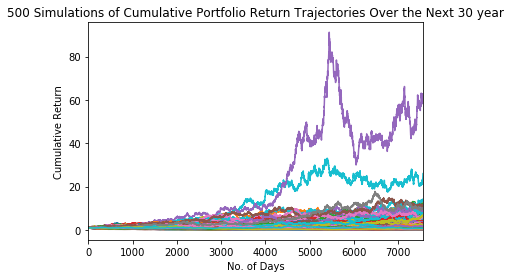

In [11]:
# Visualize the Simulation
# YOUR CODE HERE
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 year"

ax = portfolio_cumulative_returns.plot(legend=None, title=plot_title)
ax.set(xlabel='No. of Days', ylabel='Cumulative Return' )

In [12]:
portfolio_cumulative_returns.tail()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
7556,1.139617,0.766581,0.961972,0.538919,0.936719,6.710497,0.246567,1.840105,1.025316,0.738001,...,0.673635,1.542159,0.996799,0.644645,1.735558,10.381532,0.527906,9.998618,0.664445,0.816122
7557,1.130316,0.747598,0.955180,0.537420,0.935600,6.691156,0.241570,1.883142,1.020989,0.721721,...,0.666521,1.526924,1.001685,0.631773,1.733938,10.581169,0.533045,10.068745,0.672232,0.807556
7558,1.116350,0.744052,0.969403,0.538600,0.927489,6.754808,0.241768,1.899669,1.035127,0.719602,...,0.666130,1.540632,1.008418,0.627358,1.757772,10.543229,0.531949,9.822382,0.661457,0.807525
7559,1.107786,0.744460,0.973058,0.541416,0.946135,6.678551,0.239810,1.886001,1.019251,0.714958,...,0.670427,1.561324,0.986280,0.623885,1.780313,10.444546,0.536364,9.731978,0.651670,0.797212
7560,1.132695,0.754905,1.001512,0.547656,0.948390,6.675596,0.235271,1.869137,0.996990,0.711842,...,0.676026,1.546797,0.975301,0.630108,1.789236,10.430978,0.532968,9.497517,0.652979,0.806962


In [13]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
# YOUR CODE HERE
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1,:]
ending_cumulative_returns

0       1.132695
1       0.754905
2       1.001512
3       0.547656
4       0.948390
5       6.675596
6       0.235271
7       1.869137
8       0.996990
9       0.711842
10      1.055607
11      2.824970
12      0.173642
13      0.249983
14      5.546695
15      1.247401
16      0.381781
17      0.379705
18      3.710122
19      0.198378
20      0.081314
21      7.808163
22      0.167963
23      7.285612
24      5.446922
25      3.480165
26      0.174077
27      1.168787
28      0.772685
29      0.438858
         ...    
470     0.239577
471     1.073202
472     0.975304
473     0.808836
474     0.214475
475     0.323174
476     0.348374
477     0.810227
478     0.260456
479     1.269340
480     0.838057
481     2.563074
482     0.944523
483     2.991760
484     1.008252
485     2.439537
486     2.569070
487     0.389160
488     2.502510
489     1.299320
490     0.676026
491     1.546797
492     0.975301
493     0.630108
494     1.789236
495    10.430978
496     0.532968
497     9.4975

In [14]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
# YOUR CODE HERE
ending_cumulative_returns_20 = portfolio_cumulative_returns.iloc[20*252,:]
ending_cumulative_returns_20

0      0.960499
1      0.849396
2      0.550603
3      0.509354
4      2.742488
5      5.984162
6      0.374811
7      1.673460
8      0.740548
9      0.440542
10     1.584626
11     1.775720
12     0.146298
13     0.322349
14     1.643242
15     5.770855
16     0.463799
17     0.503356
18     3.036194
19     0.372656
20     0.356367
21     9.184026
22     0.202408
23     3.557455
24     2.049821
25     1.891186
26     0.178172
27     0.594121
28     1.374009
29     0.682968
         ...   
470    0.559309
471    1.623786
472    1.999294
473    0.636084
474    0.248412
475    0.277015
476    0.385427
477    0.770722
478    0.320895
479    1.248252
480    1.317982
481    1.570102
482    2.063042
483    1.745510
484    2.054230
485    1.627901
486    1.678145
487    2.048834
488    1.518577
489    3.312224
490    0.792462
491    0.682917
492    0.883750
493    0.548499
494    0.919542
495    6.634403
496    1.132157
497    7.883067
498    0.294735
499    1.406389
Name: 5040, Length: 500,

In [15]:
ending_cumulative_returns = ending_cumulative_returns_20.tail()
ending_cumulative_returns

495    6.634403
496    1.132157
497    7.883067
498    0.294735
499    1.406389
Name: 5040, dtype: float64

In [16]:
# Display the 90% confidence interval for the ending returns
# YOUR CODE HERE
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05    0.462220
0.95    7.633334
Name: 5040, dtype: float64

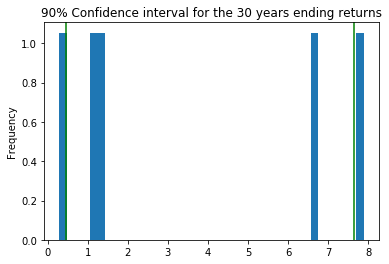

In [17]:
# Visualize the distribution of the ending returns
# YOUR CODE HERE
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=40, title='90% Confidence interval for the 30 years ending returns')
plt.axvline(confidence_interval.iloc[0], color='g')
plt.axvline(confidence_interval.iloc[1], color='g')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [18]:
# YOUR CODE HERE
expected_cumulative_returns = ending_cumulative_returns.quantile(q=[.1,.5,.9]).round(2)
expected_cumulative_returns

0.1    0.63
0.5    1.41
0.9    7.38
Name: 5040, dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [19]:
# YOUR CODE HERE
print('Expected Cumulative Return at 30 year')
print(f'10th Percentile  : {expected_cumulative_returns[0.1]}')
print(f'50th Percentile  : {expected_cumulative_returns[0.5]}')
print(f'90th Percentile  : {expected_cumulative_returns[0.9]}')

Expected Cumulative Return at 30 year
10th Percentile  : 0.63
50th Percentile  : 1.41
90th Percentile  : 7.38


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [20]:
 # Set initial investment
initial_investment = 20000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
expected_portfolio_return = expected_cumulative_returns*initial_investment
expected_portfolio_return
four_percent_return = expected_cumulative_returns * .04

In [21]:
four_percent_return.iloc[0]

0.0252

In [23]:
# YOUR CODE HERE
projected_annual_income = 6085.0

# Checks whether 4% return in retirement portfolio meets Projected annual income
if four_percent_return.iloc[0]>projected_annual_income:
    print(f"then the measurement shoes you should have enough money for retirement.")
else:
    print(f"The measurement shows you may not have enough money for retirement.")


The measurement shows you may not have enough money for retirement.


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [33]:
# YOUR CODE HERE
increased_initial_investment = initial_investment * 1.50

# Calculate the 4% return for new initial investment
new_four_percent_return = (expected_cumulative_returns[0.1]*increased_initial_investment) * 0.04

# Checks whether 4% return in retirement portfolio meets Projected annual income
if new_four_percent_return>projected_annual_income:
    print(f"The 50% increase in the initial investment amount does exceed the value at the 10th percentile which is {int(new_four_percent_return)}$ after 4% withdraw rate from the retirement portfolio")
else:
    print("The 50% increase in the initial investment amount does not exceed the value at the 10th percentile.")


The 50% increase in the initial investment amount does not exceed the value at the 10th percentile.


### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

[Text(0, 0.5, 'Portfolio Returns'), Text(0.5, 0, 'Number of Days')]

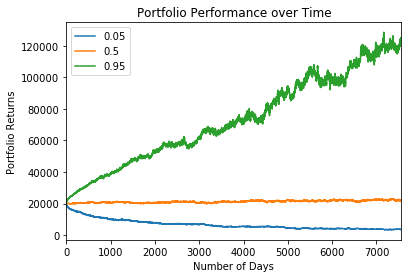

In [31]:
# YOUR CODE HERE
df90 = portfolio_cumulative_returns * initial_investment
ax = df90.swapaxes("index", "columns").quantile([0.05, 0.5, 0.95]).swapaxes('index', 'columns').plot(title='Portfolio Performance over Time')
ax.set(xlabel='Number of Days', ylabel='Portfolio Returns')